In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2
import math
from torch.nn.functional import one_hot
from torch.utils.data import DataLoader
sys.path.append('../src')

In [3]:
from main import LitClassifier
from bmdataset import CustomDataset
from trans import get_transforms
from utils import visualise_mask

In [4]:
from pycocotools.coco import COCO
from sklearn.model_selection import train_test_split#, StratifiedKFold

In [5]:
loade_model_path = '../src/model/epoch=1-val_dice_score=0.9997_.ckpt'

model = LitClassifier()
model = model.load_from_checkpoint(loade_model_path).cuda().eval()

In [6]:
cc = COCO('../data/seg_data/crop_bm_v2.json') # crop_bm-1
img_ids = cc.getImgIds()
train_img_ids, valid_img_ids = train_test_split(img_ids, test_size=0.2, shuffle=False, random_state=42)
dset = CustomDataset('../data/seg_data/crop_bm_v2.json', valid_img_ids, transform=get_transforms(data='valid'), split_patch=True)
dload = DataLoader(dset, batch_size=1, shuffle=True)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [7]:
x, y = next(iter(dload))
x = x.view(-1, 1, 256, 256)
y = y.view(-1, 256, 256)

In [8]:
def stack_patch2img(imgs):

    hs_img_list = list()
    for i in range(0, 16, 4):
        hs_img = np.hstack(imgs[i : i+ 4])
        hs_img_list.append(hs_img)
    img = np.vstack(hs_img_list)
    return img

In [9]:
x_numpy = x.detach().cpu().permute(0, 2, 3, 1).numpy()
y_numpy = y.numpy()

In [10]:
one_img = stack_patch2img(x_numpy)
one_label = stack_patch2img(y_numpy)

Text(0.5, 1.0, 'label')

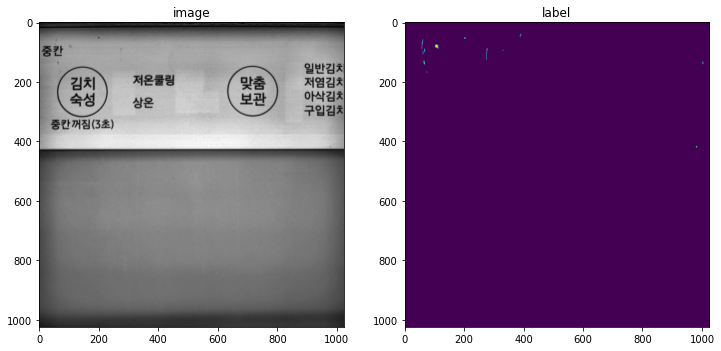

In [11]:
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.imshow(one_img, cmap='gray')
ax1.set_title('image')
ax2.imshow(one_label)
ax2.set_title('label')

In [12]:
one_img.shape

(1024, 1024, 1)

In [13]:
# idx = 8
# img = (np.clip(x_numpy, 0, 1) * 255).astype(np.uint8)
# gray_one_img = img[idx] # cv2.cvtColor(img[idx], cv2.COLOR_BGR2GRAY)

In [14]:
# plt.imshow(gray_one_img, cmap='gray')
# plt.show()

In [15]:
# cany_1 = cv2.Canny(gray_one_img, 80, 120)
# lines = cv2.HoughLinesP(cany_1, 1, math.pi/2, 2, None, 30, 1)
# img_3ch = cv2.cvtColor(gray_one_img, cv2.COLOR_GRAY2RGB)
# for line in lines[:2]:
#     pt1 = (line[0, 0],line[0, 1])
#     pt2 = (line[0, 2],line[0, 3])
#     pt_size = pt2[0] - pt1[0]
#     if pt_size > 180:
#         cv2.line(img_3ch, pt1, pt2, (0,0,255), 3)

# plt.figure(figsize=(12, 12))
# plt.imshow(img_3ch)
# plt.show()

tensor(222.)


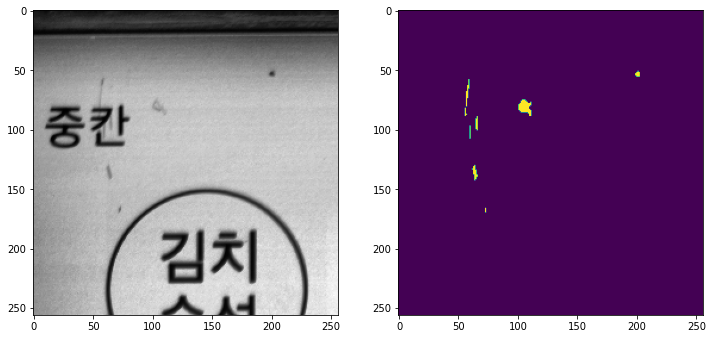

In [16]:
idx = 0
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.imshow(x[idx].permute(1,2,0), cmap='gray')
ax2.imshow(y[idx])
print(y[idx].sum())

In [17]:
one_hot_mask = one_hot(y[idx].long(), num_classes=3)
for i in range(3):
    print(one_hot_mask[..., i].sum())

tensor(65314)
tensor(222)
tensor(0)


In [18]:
# with torch.no_grad():
#     result = model(x[idx].unsqueeze(0).cuda())

with torch.no_grad():
    result = model(x.cuda())

In [19]:
result = result.sigmoid().detach().cpu()

In [20]:
result.shape

torch.Size([16, 3, 256, 256])

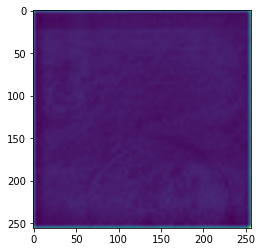

In [22]:
plt.imshow(result[idx].mean(0)) # .mean(0)

In [160]:
# for i in range(3):
#     print(result[0, i].sum())

In [161]:
# result_one_hot.shape

Text(0.5, 1.0, 'label')

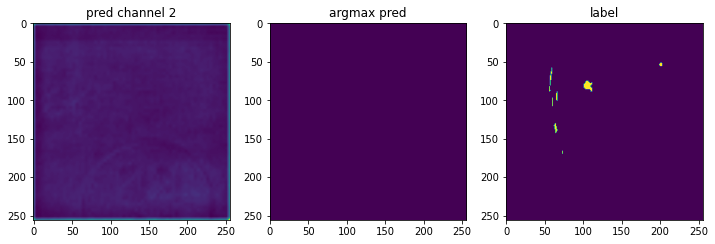

In [26]:
pred_ch = 2

fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)
mask = torch.argmax(result[idx], dim=0)
result_one_hot = result # >= 0.1
ax1.imshow(result_one_hot[idx, pred_ch])
ax1.set_title(f'pred channel {pred_ch}')
ax2.imshow(mask) # , cmap='gray'
ax2.set_title('argmax pred')
ax3.imshow(y[idx])
ax3.set_title('label')

In [163]:
flag_result = result[idx] > 0.3

In [164]:
pred_masked_img = visualise_mask((x[idx].permute(1,2,0).numpy() * 255).astype(np.uint8).copy(), flag_result.permute(1,2,0).numpy().astype(np.uint8))
label_masked_img = visualise_mask((x[idx].permute(1,2,0).numpy() * 255).astype(np.uint8).copy(), one_hot_mask.numpy().astype(np.uint8))

Text(0.5, 1.0, 'label mask image')

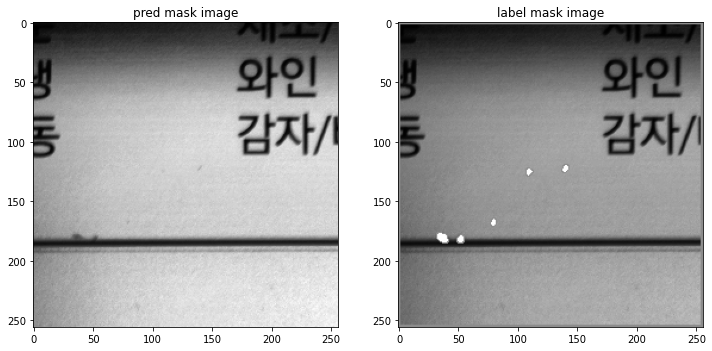

In [165]:
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.imshow(pred_masked_img, cmap='gray')
ax1.set_title('pred mask image')
ax2.imshow(label_masked_img, cmap='gray')
ax2.set_title('label mask image')

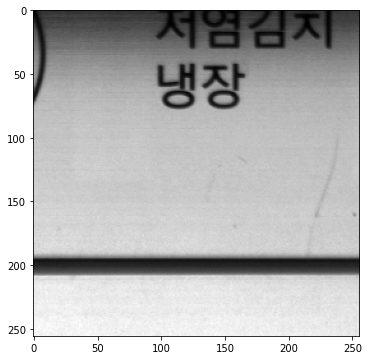

In [65]:
plt.figure(figsize=(6, 6))
plt.imshow((x[idx].permute(1,2,0).numpy() * 255).astype(np.uint8), cmap='gray')